![image](https://py-rates.fr/assets/welcomePage/logoSmall.png)

# PyratesIA - Model Training

This notebook preprocesses the features vector and train the help policies, defined as multiclass classifiers that predicts from the behavioral features, the help type to provide to the students. 
- Input: The pickles generated by the feature_engineering notebook (pickle/FEATURES, pickle/FEATURES_CONSTANTS, pickle/RECEIVED_HELP_KEYS, pickle/FEATURES_SETS_KEY, pickle/LEVELS_KEYS, pickle/TIME_FEATURES_KEYS_TOTAL) 
- Output: A dictionary with the trained models, their performance, and their predicted values on the test sets

The inputs should be as follows:
<!-- - pickle/FEATURES_CONSTANTS: the list of feature names, along with the labels (in our case "help_type") and the student ID 'in our case "student_id") -->
- pickle/RECEIVED_HELP_KEYS: the different possible value of the labels (in our case the different help types)
<!-- - pickle/FEATURES: A nested dictionary with the game levels as the first keys ("Level1", "Level2"...), feature sets as the second keys ("sum_features_nohelp", "meansd_features_nohelp"), the feature names as the third keys ("CO_avg_while_impl", "CO_avg_string_impl"...), and the computed features as the values. -->
- pickle/FEATURES: A nested dictionary with the game levels as the first keys ("Level1", "Level2"...), and the feature names as the seconde keys
  ("CO_avg_while_impl", "CO_avg_string_impl"...), and the computed features as the values.
- pickle/LEVELS_KEYS: the list of level keys, i.e., the first keys in pickle/FEATURES 
<!-- - pickle/FEATURES_SETS_KEY: the list of feature sets names, i.e., the second key in pickle/FEATURES. This is relevant only if different subsets of features are used for model training. In case only one set of features is needed, then this should just be a list with only one element (the name of the one feature set). -->
- pickle/FEATURES_SETS_KEY: the list of feature sets name. This is relevant only if different subsets of features are used for model training. In case only one set of features is needed, then this should just be a list with only one element (the name of the one feature set).
- pickle/TIME_FEATURES_KEYS_TOTAL: the time-based features keys, that we discretize for some classifiers
<!-- - pickle/LABELS_KEY : the key of the label in the pickle/FEATURES dictionary -->

The output is as follows:

    outputall = {
        "grid_results": levels_results_grid,    
        "grid_trained_classifiers": levels_grid_classifier,
        "grid_predictions": pred_results,
        "grid_true_labels": pred_labels
    }
where:
- grid_results is a dataframe with the performance of the models (by default we compute  F1 score, precision, recall)
- grid_trained_classifiers is a nested dictionary with the trained models per game level (1st key), feature sets (2nd key) and model (3rd key). When using k-folds the value is a list of model (one per fold)
- grid_predictions is a similar dictionary where the value are the model's prediction (i.e., the outputs of the models)
- grid_true_labels is the same as grid_predictions but with the true labels (necessary to compute confusing matrices)
    

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
%matplotlib inline
from dateutil import parser
from locale import normalize
import ipywidgets as widgets
from IPython import display
from statistics import mean
import pickle

from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupShuffleSplit
# from modules.ordinal import OrdinalClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE 
from copy import deepcopy

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning

from sklearn.inspection import permutation_importance


pd.options.display.max_rows = 999 #to be able to print full matrices
# from dill import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

## 1) Load Pickles

In [2]:
# with open('pickle/FEATURES_CONSTANTS', 'rb') as f:
#     ALL_KEYS = pickle.load(f)

with open('pickle/FEATURES', 'rb') as f:
    levels_processed_dataframes = pickle.load(f)
    
# with open('pickle/LABELS_KEY', 'rb') as f:
#     LABELS_KEY = pickle.load(f)
    
with open('pickle/FEATURES_SETS_KEY', 'rb') as f:
    FEATURES_SETS = pickle.load(f)
    
with open('pickle/LEVELS_KEYS', 'rb') as f:
    LEVELS_KEYS = pickle.load(f)  
        
with open('pickle/RECEIVED_HELP_KEYS', 'rb') as f:
    RECEIVED_HELP_KEYS = pickle.load(f)
    
with open('pickle/TIME_FEATURES_KEYS_TOTAL', 'rb') as f:
    TIME_FEATURES_KEYS_TOTAL = pickle.load(f)  

## 2) Constants

ML Constants

In [3]:
RAND_STATE_SEED = 42 #for reproducibility
EXPORT_SUFFIX = "_run2" #suffix to add to all exported file (for version control)
NBFOLDS = 5 # number of cross validation folds
NBFOLDS_GRID = 3 # number of inner folds for the grid search hyperparameter tuning
LABELS_KEY = "help_type" # the key of the labels in the feature dataframe
STUDENT_ID_KEY = "student_id" # the grouping key used to do cross-validation over users (effectively using the StratifiedGroupKFold function of Sklearn)
CORREL_THRESHOLD = 0.8 # thresholds for discarding correlated features (1 means no feature removal) 
SMOTE_MINORITY = True # True/False: to turn on/off Smote over-sampling of the minority classes
MAX_EXECUTION_THRESHOLD = 40 # outlier threshold: students who made too many executions are deemed outliers because this can reveals a gaming-the-system strategy

Feature keys

In [4]:
NB_USER_STOPPED_EXECUTION_KEY = "EX_tot_user_stopped"
NB_COMPLETED_EXECUTION_KEY = "EX_tot_executed"
REQUESTED_HELP_TOTAL = "FE_tot_requested"

## 3) Data filtering and outlier removal

Remove game levels where the amount of datapoints (help delivered) is too small,
either because the level is too easy, or because not enough students made it to
that level

In [5]:
# We opted to remove the game levels where the number of datapoints is substantially lower, 
# effectively less than 50 datapoints (see features_exploration).
del levels_processed_dataframes[LEVELS_KEYS[1]] #level2
del levels_processed_dataframes[LEVELS_KEYS[5]] #level6
del levels_processed_dataframes[LEVELS_KEYS[6]] #level7
del levels_processed_dataframes[LEVELS_KEYS[7]] #level8

Remove outliers, defined as rows with too many executions (indicates a notion avoidance strategy: user playing with random)

In [6]:

for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    nb_rows_before = level_processed_dataframe.shape[0]
    level_processed_dataframe = level_processed_dataframe.drop(level_processed_dataframe[level_processed_dataframe[NB_USER_STOPPED_EXECUTION_KEY] > MAX_EXECUTION_THRESHOLD].index)
    level_processed_dataframe = level_processed_dataframe.drop(level_processed_dataframe[level_processed_dataframe[NB_COMPLETED_EXECUTION_KEY] > MAX_EXECUTION_THRESHOLD].index)
    nb_rows_after = level_processed_dataframe.shape[0]
    print("Nb deleted rows: ",(nb_rows_before-nb_rows_after))


------------------ Level1 ------------------
Nb deleted rows:  0
------------------ Level3 ------------------
Nb deleted rows:  0
------------------ Level4 ------------------
Nb deleted rows:  3
------------------ Level5 ------------------
Nb deleted rows:  9


## 4) Create the feature sets

Here a feature set is defined as a subset of the features (i.e., a subset of pickle/FEATURES_CONSTANTS). The goal being to train the models on different subsets of features rather than just using all of the available features.

In [7]:
# Based on the levels_processed_dataframes dataframe, create one dataframe per feature set defined above in FEATURES_SETS

levels_featuresets_dataframes = {}
print("-------------------------------------(nbdatapoints, nbfeatures)")
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    levels_featuresets_dataframes[level_key] = {}
    for fset_key, fset_columns in FEATURES_SETS.items():
        levels_featuresets_dataframes[level_key][fset_key] = level_processed_dataframe[fset_columns]
        print(level_key, "-", fset_key, ": ", levels_featuresets_dataframes[level_key][fset_key].shape)
    print()

#levels_featuresets_dataframes["Level1"]["sum_features_help_received"]

-------------------------------------(nbdatapoints, nbfeatures)
Level1 - all_features_help_received :  (176, 177)
Level1 - all_features_help_requested :  (176, 174)
Level1 - all_features_nohelp :  (176, 171)
Level1 - sum_features_help_received :  (176, 71)
Level1 - sum_features_help_requested :  (176, 68)
Level1 - sum_features_nohelp :  (176, 66)
Level1 - mean_sd_rate_features_help_received :  (176, 113)
Level1 - mean_sd_rate_features_help_requested :  (176, 110)
Level1 - mean_sd_rate_features_nohelp :  (176, 108)

Level3 - all_features_help_received :  (408, 177)
Level3 - all_features_help_requested :  (408, 174)
Level3 - all_features_nohelp :  (408, 171)
Level3 - sum_features_help_received :  (408, 71)
Level3 - sum_features_help_requested :  (408, 68)
Level3 - sum_features_nohelp :  (408, 66)
Level3 - mean_sd_rate_features_help_received :  (408, 113)
Level3 - mean_sd_rate_features_help_requested :  (408, 110)
Level3 - mean_sd_rate_features_nohelp :  (408, 108)

Level4 - all_features_

## 5) ML pipeline steps

### 5.1) Create the k-folds group

By default we used stratified k-folds over students. Stratification means that the label distribution remains balanced across the groups. "Over students" means that all of the datapoints pertaining to a student (eg all of the help they received) are within the same fold, to avoid data contamination.

In [8]:
levels_train_sets = {}
levels_test_sets = {}
level_train_set_index = []
level_test_set_index = []
cv_split_indices = {}
# test_set_ratio = 1.0 / NBFOLDS
# print("test_set_ratio = ", test_set_ratio)

for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    cv_split_indices[level_key] = []
    # Detour of StratifiedGroupKFold to get stratified AND group aware train-test split
    cv = StratifiedGroupKFold(n_splits=NBFOLDS,shuffle=True, random_state = RAND_STATE_SEED)
    for level_train_set_index, level_test_set_index in cv.split(level_processed_dataframe,y=level_processed_dataframe[LABELS_KEY], groups=level_processed_dataframe[STUDENT_ID_KEY]):
        cv_split_indices[level_key].append( (level_train_set_index, level_test_set_index) )
       
# Print the fold sizes
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    for k in range(NBFOLDS):
        (level_train_set_index, level_test_set_index) = cv_split_indices[level_key][k]
        print(k, ": ", len(level_train_set_index), "/", len(level_test_set_index))
        #print (cv_split_indices[level_key][k][1])

------------------ Level1 ------------------
0 :  143 / 33
1 :  146 / 30
2 :  141 / 35
3 :  141 / 35
4 :  133 / 43
------------------ Level3 ------------------
0 :  330 / 78
1 :  324 / 84
2 :  330 / 78
3 :  317 / 91
4 :  331 / 77
------------------ Level4 ------------------
0 :  268 / 70
1 :  279 / 59
2 :  268 / 70
3 :  271 / 67
4 :  266 / 72
------------------ Level5 ------------------
0 :  127 / 37
1 :  129 / 35
2 :  128 / 36
3 :  133 / 31
4 :  139 / 25


------------------ Level1 ------------------


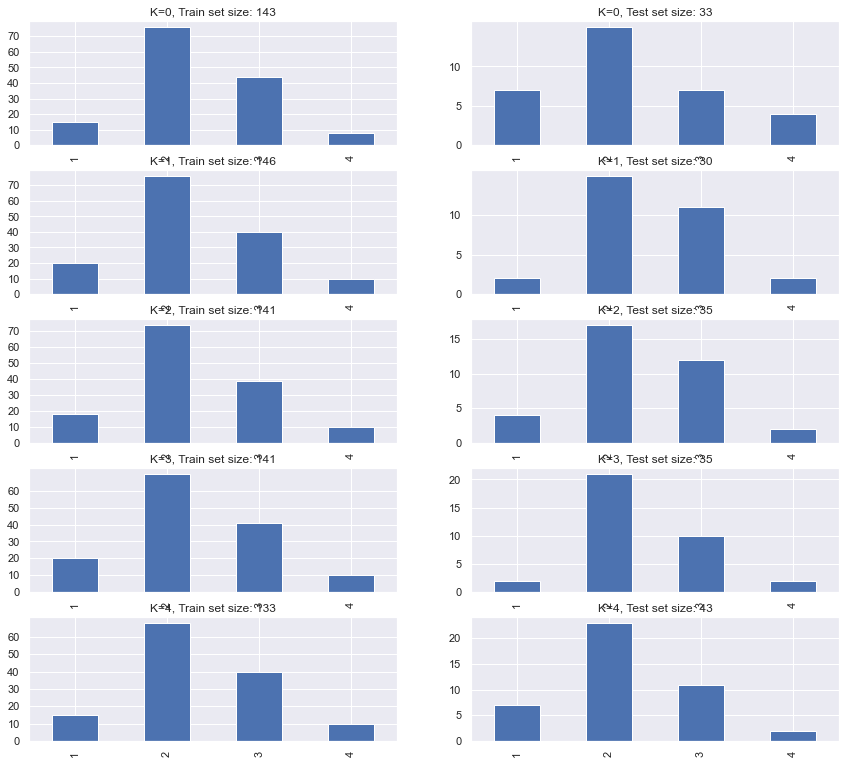

------------------ Level3 ------------------


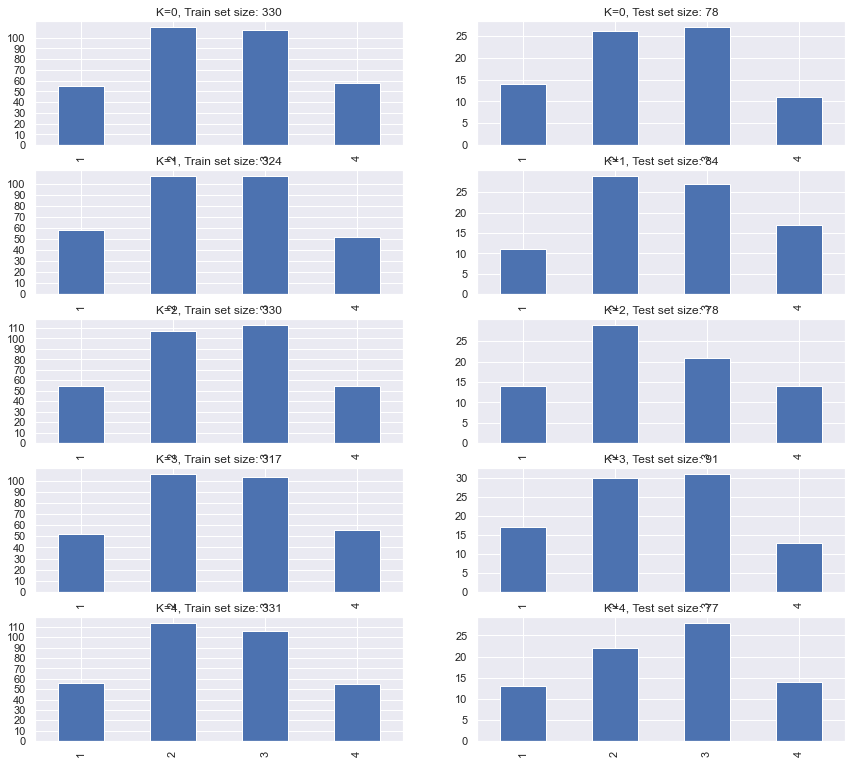

------------------ Level4 ------------------


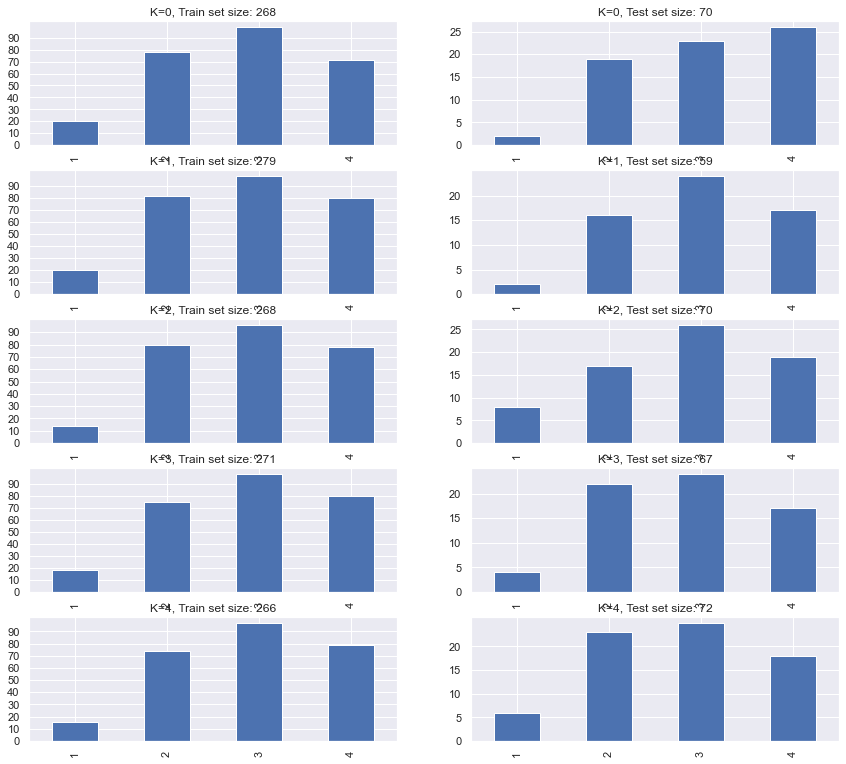

------------------ Level5 ------------------


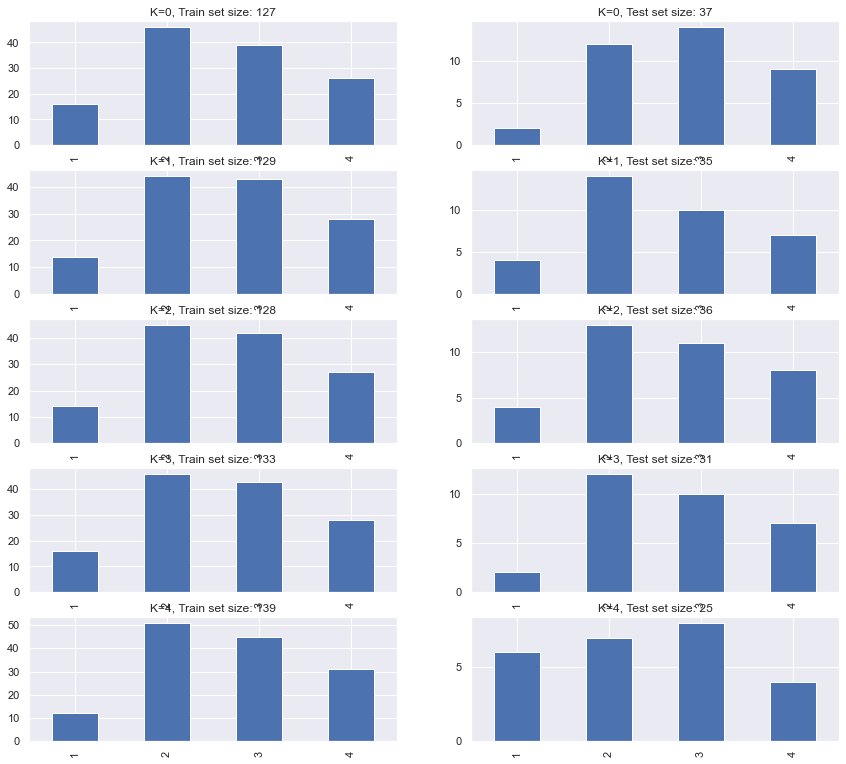

In [9]:
# Show the label distribution per folds
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    fig = plt.figure()
    for k in range(NBFOLDS):
        (level_train_set_index, level_test_set_index) = cv_split_indices[level_key][k]
    
        level_train_set = level_processed_dataframe.iloc[level_train_set_index]
        level_test_set = level_processed_dataframe.iloc[level_test_set_index]

        #  Display class distribution
        train_counts = level_train_set[LABELS_KEY].value_counts(normalize=False).sort_index()
        ax = plt.subplot(NBFOLDS, 2, k*2+1)
        ax.title.set_text("K={}, Train set size: {}".format(k, len(level_train_set)))
        train_counts.plot(kind='bar')
        plt.yticks(np.arange(0, max(train_counts), 10))
        #plt.show()
        
        test_counts = level_test_set[LABELS_KEY].value_counts(normalize=False).sort_index()
        ax = plt.subplot(NBFOLDS, 2, k*2+2)
        ax.title.set_text("K={}, Test set size: {}".format(k, len(level_test_set)))
        test_counts.plot(kind='bar')
        plt.yticks(np.arange(0, max(test_counts), 5))
        
        """levels_train_sets[level_key]= level_train_set
        levels_test_sets[level_key]= level_test_set"""
    plt.subplots_adjust(bottom=1.5, right=2,top=4)
    plt.show()

### 5.2) Function to split the features and labels

In [10]:
def feature_label_group_split(dataset):
    dataset_features = dataset.drop(columns=[LABELS_KEY,STUDENT_ID_KEY]) #remove the labels and student_id from the predictors
    dataset_labels = dataset[LABELS_KEY].copy()
    dataset_groups = dataset[STUDENT_ID_KEY].copy()
    return (dataset_features, dataset_labels, dataset_groups)

def feature_label_split(dataset):
    dataset_features = dataset.drop(columns=[LABELS_KEY,STUDENT_ID_KEY])
    dataset_labels = dataset[LABELS_KEY].copy()
    return (dataset_features, dataset_labels)

### 5.3) Functions for feature selections

In [11]:
# Create a custom transformer to delete irrelevant features (all values are the same)
# class DeleteIrrelevantFeatures(BaseEstimator, TransformerMixin):
#     def __init__(self): # no *args or ** kargs
#         pass
#     def fit(self, X, y = None):
#         self.unused_features = []
#         for key in X.columns:
#             nb_values = X[key].value_counts()
#             if len(nb_values) == 1: # If all the values are the same
#                 # print("Deleted feature :",key)
#                 self.unused_features.append(key)
#         # print("Remain features: ",len(X.columns)-len(self.unused_features))
#         return self
#     def transform(self, X, y = None):
#         # print("Number of deleted features",len(self.unused_features))
#         modified_X = X.drop(columns=self.unused_features)    
#         return modified_X

In [12]:
# Create a custom transformer to delete highly correlated features
class DeleteCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold = 0.9): # no *args or ** kargs
        self.threshold = threshold
        self.to_drop = []
        
    def fit(self, X, y = None):
        if isinstance(X, pd.DataFrame):
            corr_matrix = X.corr().abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            self.to_drop = [column for column in upper.columns if any(upper[column] >= self.threshold)]
        else:
            corr_matrix = np.absolute(np.corrcoef(X, rowvar=False))
            upper = corr_matrix*np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
            self.to_drop = [column for column in range(upper.shape[1]) if any(upper[:,column] >= self.threshold)]
        return self
    
    def transform(self, X, y = None):
        if isinstance(X, pd.DataFrame):
            X_reduced = X.drop(columns = self.to_drop)
        else:
            X_reduced = np.delete(X, self.to_drop, axis=1)
        return X_reduced

In [13]:
# Create a custom transformer to discretize time features (used only for the Naive Bayes Classifier as it does not handles continuous data)
class TimeSpendDiscretizer(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or ** kargs
        pass
    def fit(self, X, y = None):
        self.discretizer = {}
        for time_feature in TIME_FEATURES_KEYS_TOTAL:
            if time_feature in X.columns:
                self.discretizer[time_feature] = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
                self.discretizer[time_feature].fit(X[[time_feature]])
        return self
    def transform(self, X, y = None):
        modified_X = X.copy()
        for time_feature in TIME_FEATURES_KEYS_TOTAL:
            if time_feature in modified_X.columns:
                modified_X[time_feature] = self.discretizer[time_feature].transform(modified_X[[time_feature]])
        return modified_X


In [14]:
# transformer to normalize the features
data_scaler = MinMaxScaler()

### 5.4) Model evaluation function

evaluate_model(): train and test the models in k-folds cross validation over students, and compute the F1, Precision and Recall.
This is the "simple approach" that trains the models without hyperparameter tuning.

In [15]:
def evaluate_model(pipeline, features, labels, train_groups, scores = ["precision_weighted", "recall_weighted", "f1_weighted"]):
    stratified_group_cross_val = StratifiedGroupKFold(n_splits=NBFOLDS,shuffle = True, random_state = RAND_STATE_SEED)
    results = cross_validate(pipeline,features,labels,cv=stratified_group_cross_val, scoring = scores, groups=train_groups)
    return results


### 5.5) Pipeline definition for each classifier we consider (based on Sklearn)

We define one pipeline per classifier, and simply save the different pipelines in a list. This means more pipeline can be added (or deleted) as needed.

In [16]:
#Dummy baseline from sklearn
dummy_random_clf_pipe = Pipeline([
    ("dummy_random_clf", DummyClassifier(strategy="uniform"))
])

In [17]:
# Ordered baseline
# This custom baseline is based on the simple approach of delivering the help type in an ordered manner, granted that there is some notions of ordering.
# In our case the help types of ordered based on how much they reveal about the final solutions, from simply reminded the goal of the game level to directly providing the correct solution.

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class OrderedBaseline(BaseEstimator):
    def __init__(self, random_state=None):
        self.random_state = random_state

    # fit model (Nothing to do for the baseline)
    def fit(self, X=None, y=None):
        pass

    # Predict (Escalate help level)
    def predict(self, X):
        res = []
        
        # Check if help received available
        if all(value in X.columns for value in RECEIVED_HELP_KEYS):
            for ind,row in X.iterrows():
                help_l = [row[RECEIVED_HELP_KEYS[0]], row[RECEIVED_HELP_KEYS[1]], \
                           row[RECEIVED_HELP_KEYS[2]], row[RECEIVED_HELP_KEYS[3]] ]
                help_given_index = [i for i, x in enumerate(help_l) if x > 0]
                if len(help_given_index) == 0: #no help ever given = predict first help
                    res.append(0)
                else: #predict the next help level
                    max_help = max(help_given_index)
                    res.append(min(max_help+1, 3))
        
        # Check if help count available
        elif REQUESTED_HELP_TOTAL in X.columns:
            for ind,row in X.iterrows():
                if row[REQUESTED_HELP_TOTAL] == 0: #no help ever given = predict first help
                    res.append(0)
                else: #predict the next help level
                    res.append(int(min(row[REQUESTED_HELP_TOTAL]+1, 3)))
                
        # Otherwise cannot do the prediction
        else:
            res = [-1]*len(X.index)
        return res

#TEST
"""for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        print(f"    --------------- {fset_key} ---------------")    
        fset_dataframe = level_processed_dataframe[fset_columns]
        level_features, level_labels, level_groups  = feature_label_group_split(fset_dataframe)
        clf = OrderedBaseline()
        clf.fit(level_features, level_labels)
        print(clf.predict(level_features))
    break"""
    

# Important to not remove any features as part of the pipeline as we need to keep the features on previous help received
ordered_clf_pipe = Pipeline([
    ("dummy_random_clf", OrderedBaseline())
])



In [18]:
# Multinomial Naive Bayes classifier

naive_bayes_clf_pipe = Pipeline([
    ("time_spend_discretizer",TimeSpendDiscretizer()),
    ("feature_deleter",VarianceThreshold()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    ("data_scaler", MinMaxScaler()),
    ("naive_bayes_clf", MultinomialNB())
])

In [19]:
# Logistic regression

logistic_regression_clf_pipe = Pipeline([
    ("feature_deleter",VarianceThreshold()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    ("data_scaler", MinMaxScaler()),
    ("logistic_regression_clf", LogisticRegression(random_state=RAND_STATE_SEED))
])

In [20]:
# SVM

svm_clf_pipe = Pipeline([
    ("feature_deleter",VarianceThreshold()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    ("data_scaler", MinMaxScaler()),
    ("svm_gaussian_clf", SVC(kernel="rbf"))
])

In [21]:
# Decision tree

decision_tree_clf_pipe = Pipeline([
    ("feature_deleter",VarianceThreshold()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    ("data_scaler", MinMaxScaler()),
    ("decision_tree_clf", DecisionTreeClassifier(random_state = RAND_STATE_SEED))
])

In [22]:
#Random Forests

random_forest_clf_pipe = Pipeline([
    ("feature_deleter",VarianceThreshold()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    ("data_scaler", MinMaxScaler()),
    ("random_forest_clf", RandomForestClassifier(random_state = RAND_STATE_SEED))
])

In [23]:
#Crate the final list of all classifiers
classifiers = {
    "Dummy random": dummy_random_clf_pipe,
    "Ordered baseline": ordered_clf_pipe,
    "Naive Bayes": naive_bayes_clf_pipe,
    "Logistic regression":logistic_regression_clf_pipe,
    "SVM": svm_clf_pipe,
    "Decision Tree":decision_tree_clf_pipe,
    "Random Forest": random_forest_clf_pipe
}

## 6) Model training and evaluation (no hyper-parameter tuning)

Here we first train and evaluate the models using the default values in Sklearn for the hyperparameters of the models.
We compute the F1 score, precision and recall using the evaluate_model() function in stratified k-folds cross validation over students (k=NBFOLDS).

In [24]:
metrics = [
    "Precision_m",
    "Precision_std",
    "Recall_m",
    "Recall_std",
    "F1_score_m",
    "F1_score_std"
]

fold_results = []

# Iterate over the game levels, feature sets and folds to train the models
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")         
    for fset_key, fset_columns in FEATURES_SETS.items():
        print(f"    --------------- {fset_key} ---------------")    
        fset_dataframe = level_processed_dataframe[fset_columns]
        level_features, level_labels, level_groups = feature_label_group_split(fset_dataframe)

        for classifier_name, classifier in classifiers.items():
            cv_results = evaluate_model(classifier, level_features, level_labels, level_groups)
            for k in range(NBFOLDS):
                fold_results.append({
                    "level_key": level_key,
                    "features_set": fset_key,
                    "K": k,
                    "classifier": classifier_name,
                    "Precision":cv_results["test_precision_weighted"][k],
                    "Recall":cv_results["test_recall_weighted"][k],
                    "F1_score":cv_results["test_f1_weighted"][k]
                })

levels_results = pd.DataFrame.from_records(fold_results) 
print("Done")

------------------ Level1 ------------------
    --------------- all_features_help_received ---------------


    --------------- all_features_help_requested ---------------
    --------------- all_features_nohelp ---------------
    --------------- sum_features_help_received ---------------
    --------------- sum_features_help_requested ---------------
    --------------- sum_features_nohelp ---------------
    --------------- mean_sd_rate_features_help_received ---------------
    --------------- mean_sd_rate_features_help_requested ---------------
    --------------- mean_sd_rate_features_nohelp ---------------
------------------ Level3 ------------------
    --------------- all_features_help_received ---------------
    --------------- all_features_help_requested ---------------
    --------------- all_features_nohelp ---------------
    --------------- sum_features_help_received ---------------
    --------------- sum_features_help_requested ---------------
    --------------- sum_features_nohelp ---------------
    --------------- mean_sd_rate_features_help_received ---------------
    

In [25]:
#print results
pd.pivot_table(levels_results.drop("K", axis=1), index=['level_key','features_set','classifier'], aggfunc='mean')

F1_score  \
level_key features_set                         classifier                      
Level1    all_features_help_received           Decision Tree        0.706476   
                                               Dummy random         0.262112   
                                               Logistic regression  0.726314   
                                               Naive Bayes          0.658791   
                                               Ordered baseline     0.000000   
                                               Random Forest        0.718364   
                                               SVM                  0.702411   
          all_features_help_requested          Decision Tree        0.689558   
                                               Dummy random         0.289374   
                                               Logistic regression  0.666901   
                                               Naive Bayes          0.557190   
                                               Ordered baseline     0.549310   
                                               Random Forest        0.712361   
                                               SVM                  0.633060   
          all_features_nohelp                  Decision Tree        0.668100   
                                               Dummy random         0.216294   
                                               Logistic regression  0.664404   
                                               Naive Bayes          0.520407   
                                               Ordered baseline     0.000000   
                                               Random Forest        0.707215   
                                               SVM                  0.591804   
          mean_sd_rate_features_help_received  Decision Tree        0.637231   
                                               Dummy random         0.318000   
                                               Logistic regression  0.712174   
                                               Naive Bayes          0.670213   
                                               Ordered baseline     0.000000   
                                               Random Forest        0.738386   
                                               SVM                  0.706861   
          mean_sd_rate_features_help_requested Decision Tree        0.652356   
                                               Dummy random         0.269453   
                                               Logistic regression  0.701412   
                                               Naive Bayes          0.527157   
                                               Ordered baseline     0.549310   
                                               Random Forest        0.700947   
                                               SVM                  0.650476   
          mean_sd_rate_features_nohelp         Decision Tree        0.640797   
                                               Dummy random         0.195558   
                                               Logistic regression  0.641797   
                                               Naive Bayes          0.484403   
                                               Ordered baseline     0.000000   
                                               Random Forest        0.682558   
                                               SVM                  0.592181   
          sum_features_help_received           Decision Tree        0.697078   
                                               Dummy random         0.270077   
                                               Logistic regression  0.653545   
                                               Naive Bayes          0.667585   
                                               Ordered baseline     0.000000   
                                               Random Forest        0.729632   
                                               SVM                  

## 7) Model training and evaluation with hyper-parameter tuning

We repeat the process of 6) but this time with hyper-parameter tuning, using the GridSearch mechanism from Sklearn. This means we use stratified nested cross-validation over students, with the grid search applied at the inner loop of the nested cross validation.

Notice that we have defined a small and a large grid for each hyperparameter (cf. code below), but we typically use the small one.

In [26]:
levels_results_grid = {}

#this is for the inner level of the nested cross-validation
stratified_group_cross_val = StratifiedGroupKFold(n_splits=NBFOLDS_GRID, shuffle = True, random_state = RAND_STATE_SEED)

#define the grid for each model
param_grid_nb = [{
    # Default value in sklearn: 1.0
    #'naive_bayes_clf__alpha': [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001] #large grid
    'naive_bayes_clf__alpha': [1.0, 0.1, 0.01] #small grid
}]

param_grid_lr = [{
    # Default value in sklearn: 1.0
    #'logistic_regression_clf__C': [100.0, 50.0, 25.0, 10.0, 5.0, 1.0, 0.5, 0.1], #large grid
    'logistic_regression_clf__C': [100.0, 10.0, 1.0], #small grid
    # Default: 100
    'logistic_regression_clf__max_iter': [200]
}]

param_grid_svm = [{
    # Default value in sklearn: 1.0
    #'svm_gaussian_clf__C': [100.0, 50.0, 25.0, 10.0, 5.0, 1.0, 0.5, 0.1], #large grid
    'svm_gaussian_clf__C': [100.0, 10.0, 1.0], #small grid
    # Default value in sklearn: 1.0
    #'svm_gaussian_clf__gamma': [10, 1.0, 0.5, 0.1, 0.01, 0.001, 0.0001], #large grid
    'svm_gaussian_clf__gamma': [1.0, 0.1, 0.01], #small grid
    # Default value in sklearn: rbf
    'svm_gaussian_clf__kernel': ['rbf', 'poly', 'sigmoid']
}]

        
param_grid_rf = [{
    # Default value in sklearn: 100
    #"random_forest_clf__n_estimators": [20, 50, 100, 200, 500], #large grid
    "random_forest_clf__n_estimators": [50, 100, 200], #small grid
    # Default value in sklearn: None
    #"random_forest_clf__max_depth" : [4,6,8,10,12,14,16,18,None],    #large grid
    "random_forest_clf__max_depth" : [6,12,None],    #small grid
}]


#add all of the grids in a dict
grids = {
    "Dummy random": dummy_random_clf_pipe,
    "Ordered baseline": ordered_clf_pipe,
    "Naive Bayes": GridSearchCV( 
                                estimator = naive_bayes_clf_pipe,
                                param_grid = param_grid_nb,
                                cv = stratified_group_cross_val,
                                verbose = 1,
                                scoring ='f1_weighted',
                                n_jobs=-1),
    "Logistic regression": GridSearchCV( 
                                estimator = logistic_regression_clf_pipe,
                                param_grid = param_grid_lr,
                                cv = stratified_group_cross_val,
                                verbose = 1,
                                scoring ='f1_weighted',
                                n_jobs=-1),
    "SVM": GridSearchCV( 
                                estimator = svm_clf_pipe,
                                param_grid = param_grid_svm,
                                cv = stratified_group_cross_val,
                                verbose = 1,
                                scoring ='f1_weighted',
                                n_jobs=-1),
    "Random Forest": GridSearchCV( 
                                estimator = random_forest_clf_pipe,
                                param_grid = param_grid_rf,
                                cv = stratified_group_cross_val,
                                verbose = 1,
                                scoring ='f1_weighted',
                                n_jobs=-1)
}


if SMOTE_MINORITY: # Oversample minority classes with SMOTE
    smoter = SMOTE(random_state=RAND_STATE_SEED)
        
fold_results = []
pred_results = {}
pred_labels = {}
levels_grid_classifier = {}

# Iterate over the game level, feature sets and fold to train the models
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    pred_results[level_key] = {}
    pred_labels[level_key] = {}
    levels_grid_classifier[level_key] = {}
       
    for fset_key, fset_columns in FEATURES_SETS.items():
        print(f"    --------------- {fset_key} ---------------")
        pred_results[level_key][fset_key] = {}
        pred_labels[level_key][fset_key] = {}
        levels_grid_classifier[level_key][fset_key] = {}
        
        # Keep only features relevant to the current features sets
        fset_dataframe = level_processed_dataframe[fset_columns]
    
        for k in range(NBFOLDS):
            print(f"------------------ {k} ------------------")      
            (level_train_set_index, level_test_set_index) = cv_split_indices[level_key][k]
            level_train_set = fset_dataframe.iloc[level_train_set_index]
            level_test_set = fset_dataframe.iloc[level_test_set_index]

            #level_features, level_labels, level_groups  = feature_label_group_split(fset_dataframe) #for the baselines
            level_train_set_features, level_train_set_labels, level_train_set_groups  = feature_label_group_split(level_train_set)
            level_test_set_features, level_test_set_labels  = feature_label_split(level_test_set)
            
            if SMOTE_MINORITY: # Oversample minority classes, in the train sets ONLY
                (level_train_set_features, level_train_set_labels) = smoter.fit_resample(level_train_set_features, level_train_set_labels)
                level_train_set_groups = range(0, len(level_train_set_labels)) # Within-train-set groups make no sense anymore with SMOTE
                
            for classifier_name, grid_pipeline in grids.items():
                if classifier_name not in pred_results[level_key][fset_key]: pred_results[level_key][fset_key][classifier_name] = [] 
                if classifier_name not in pred_labels[level_key][fset_key]: pred_labels[level_key][fset_key][classifier_name] = []
                if classifier_name not in levels_grid_classifier[level_key][fset_key]: levels_grid_classifier[level_key][fset_key][classifier_name] = []

                if classifier_name == "Dummy random" or classifier_name == "Ordered baseline": # No grid search for the baselines
                    grid_pipeline.fit(level_train_set_features,level_train_set_labels)
                    grid_predictions = grid_pipeline.predict(level_test_set_features)
                    fold_results.append({
                        "level_key": level_key,
                        "features_set": fset_key,
                        "K": k,
                        "classifier": classifier_name,
                        "grid_F1": "",
                        "grid_params": "",
                        "precision": precision_score(level_test_set_labels, grid_predictions, average='weighted'),
                        "recall": recall_score(level_test_set_labels, grid_predictions, average='weighted'),
                        "f1_score":f1_score(level_test_set_labels, grid_predictions, average='weighted')
                    })
                    pred_results[level_key][fset_key][classifier_name] += list(grid_predictions)
                    pred_labels[level_key][fset_key][classifier_name] += list(level_test_set_labels)  
                else:
                    grid_pipeline.fit(level_train_set_features,y=level_train_set_labels, groups=level_train_set_groups)
                    grid_predictions = grid_pipeline.predict(level_test_set_features)
                    print(classifier_name)
                    print(f"--Best score: {f1_score(level_test_set_labels, grid_predictions, average='weighted')}")
                    print("--Best params: ",grid_pipeline.best_params_)

                    fold_results.append({
                        "level_key": level_key,
                        "features_set": fset_key,
                        "K": k,
                        "classifier": classifier_name,
                        "grid_F1": grid_pipeline.best_score_,
                        "grid_params" : str(grid_pipeline.best_params_),
                        "precision": precision_score(level_test_set_labels, grid_predictions, average='weighted'),
                        "recall": recall_score(level_test_set_labels, grid_predictions, average='weighted'),
                        "f1_score":f1_score(level_test_set_labels, grid_predictions, average='weighted')
                    })

                    levels_grid_classifier[level_key][fset_key][classifier_name].append(deepcopy(grid_pipeline.best_estimator_))
                    pred_results[level_key][fset_key][classifier_name] += list(grid_predictions)
                    pred_labels[level_key][fset_key][classifier_name] += list(level_test_set_labels)

levels_results_grid = pd.DataFrame.from_records(fold_results) 
print("Done")

------------------ Level1 ------------------
    --------------- all_features_help_received ---------------
------------------ 0 ------------------


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6961926961926961
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5797716469507912
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5893746986726114
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.5118267312624679
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 1 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5617963314358002
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.463756164605061
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5171428571428572
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.8052360916316036
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 200}
------------------ 2 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6444495980210266
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6761904761904762
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6742590742590743
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7471972789115646
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 50}
------------------ 3 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.7713043478260869
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.7959375524592917
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, 

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5926346801346802
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.48510313216195566
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'poly'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6339712918660286
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 50}
------------------ 1 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5384494027496056
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5563769414575865
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5307659932659932
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'poly'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7232961190855927
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 50}
------------------ 2 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5558518518518518
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.681891156462585
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.7294723294723294
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7758275518644181
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 3 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6907854050711194
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.7875510204081634
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.775998329156224
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7676008202323991
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 50}
------------------ 4 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.7674418604651163
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6424616358171175
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5623493038811543
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.8094389331598634
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 100}
    --------------- all_features_nohelp ---------------
------------------ 0 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5244708153799063
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.5938499711804447
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.7161904761904763
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.7667339079405833
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.8620408163265307
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 4 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6449938949938949
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6656976744186046
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6840819202945448
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'sigmoid'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7632135306553912
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 50}
    --------------- sum_features_help_received ---------------
------------------ 0 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.7018907018907019
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.5079189460528202
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regress

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.663079365079365
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6289754689754691
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6906760497302369
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
------------------ 3 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5646477946017117
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.7002597402597405
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5235143644234554
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5542588042588042
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.5719295072743349
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 1 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5551373954599761
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.604093567251462
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.7105214294154386
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6791850238854846
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7094505494505494
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 200}
------------------ 3 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.7248979591836735
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.7438095238095238
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6945982717411289
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.8337662337662337
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 4 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.7190004948045523
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.7429082545361615
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidate

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.7438095238095238
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.7167681107530731
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.8062585034013606
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 50}
------------------ 4 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6758280479210712
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.6751151556004943
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6755161194912747
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6465850340136053
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6779591836734694
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 3 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6771833057547342
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6876190476190475
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6815406815406816
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'sigmoid'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.8062585034013606
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 50}
------------------ 4 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5969531998846049
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6239713774597496
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5953488372093023
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7397681487241112
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ Level3 ------------------
    --------------- all_features_help_received ---------------
------------------ 0 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.7274264406617348
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.7691035816035816
--Best params:  {'logistic_r

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5272893772893773
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5820093061472372
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.01, 'svm_gaussian_clf__kernel': 'sigmoid'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.5743158106354233
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ 1 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6453600308047747
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.6810086793338025
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candid

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5062200956937798
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5707958707958709
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6399807376206447
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
    --------------- sum_features_help_received ---------------
------------------ 0 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.662027251358636
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.6861799085475287
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_cl

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6804922287292879
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6410636575471741
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7211965811965811
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 200}
------------------ 3 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.46764731342295585
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.5785143758358043
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candid

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6891381456318343
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.7563690722886636
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7640581640581641
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
    --------------- mean_sd_rate_features_help_requested ---------------
------------------ 0 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.49641979609997944
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.5888546151704047
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6309853249475891
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6910457963089542
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.01, 'svm_gaussian_clf__kernel': 'sigmoid'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6880831094193163
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ 2 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6017319787131109
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5966080725501016
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6447978303747535
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7336000955566173
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 3 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5935711292080874
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.547035054497741
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5959959580649237
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.01, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6916509126466754
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ 4 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5296757749587938
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5865359891184856
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5594250510679617
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7321757952192735
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
    --------------- mean_sd_rate_features_nohelp ---------------
------------------ 0 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.4556106929972628
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.47034027491093683
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regres

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.4717152319723915
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.4832577722221186
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'poly'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.5811835460745873
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ 4 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.4828048399476971
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.49305789610520967
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5021820640481899
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6142093200916731
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
------------------ Level4 ------------------
    --------------- all_features_help_received ---------------
------------------ 0 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.7041861364442009
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.7021680216802169
--Best params:  {'logistic_

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6196835688361113
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6442016937994443
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7324798653684337
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6572198976302319
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.6424368570066997
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidate

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6359747344243468
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.7383330857595564
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6968691277201916
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 200}
    --------------- all_features_help_requested ---------------
------------------ 0 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6155139938458754
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.5783868207103123
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regressi

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6290159700958152
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6049516052332161
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7183076863743298
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 4 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5990884454299089
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5788671023965141
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6824618736383443
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.01, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6030923267765372
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
    --------------- all_features_nohelp ---------------
------------------ 0 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5828169449598021
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.6008311668698287
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__m

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5669221835075494
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5637183868762816
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6495630725201431
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 3 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5286595435849166
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.6498696667143081
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candid

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5989371242568173
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5938971703358279
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6585157562167234
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 200}
------------------ 3 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5276153266565641
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.6418212886933116
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candid

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6929036137991362
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6471963600514395
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7908049040511728
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 4 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6376818783068783
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.7024831386455291
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.725658047985092
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7160625519136157
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
    --------------- mean_sd_rate_features_help_requested ---------------
------------------ 0 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6042774685631829
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.6608790884774962
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6013744536427176
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5686461733103524
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7732301637708116
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 4 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6032034038627914
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.6315115133180931
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candida

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5825720986068846
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5711373683787477
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6519480519480519
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5291686315847873
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.5429017910806587
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candida

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.4634156675814917
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5587414965986395
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.5465079772602237
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 50}
------------------ 3 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5400917490469729
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5628997867803838
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6074423027746368
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7514303482587065
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 4 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.486630983142611
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.5722328113316486
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidat

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.4594982078853047
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.4740340304856434
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.5476702508960574
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ 4 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.38058823529411767
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.4223589743589743
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidate

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.43018018018018017
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.4214649432040736
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.5316485316485317
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ 1 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5953939393939395
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.6159232072275551
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidate

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVM
--Best score: 0.591053391053391
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6306973026973027
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 50}
------------------ 2 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.6189066608930207
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.6504884004884005
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.6431565656565658
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'poly'}
Fitting 3 folds for each of 9 candidates, 

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.46933711449840476
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.48931623931623924
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.4820599886813809
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
------------------ 4 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.26397759103641455
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.17634188034188036
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candid

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.2775091575091575
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.39953216374269007
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.3554285714285714
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
    --------------- mean_sd_rate_features_help_requested ---------------
------------------ 0 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.502960102960103
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.47747747747747743
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5018365734155207
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.6068497647445015
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ 1 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5517282717282718
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.625152625152625
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5540917107583774
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5925925925925926
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.7189153439153438
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ 3 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5234391601853033
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.5870101224939934
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.278017094017094
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.3271255060728745
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.35984962406015036
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
    --------------- mean_sd_rate_features_nohelp ---------------
------------------ 0 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.45656370656370654
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.4117252430295908
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.5581081081081081
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.5860597439544808
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes
--Best score: 0.5091898577612863
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic regression
--Best score: 0.5922448979591838
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates

c:\Users\Branthôme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.2723982683982684
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
SVM
--Best score: 0.3771628371628372
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'sigmoid'}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Random Forest
--Best score: 0.38
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 50}
Done


In [27]:
#display results
pd.pivot_table(levels_results_grid.drop("K", axis=1), index=['level_key','features_set','classifier'], aggfunc='mean')

f1_score  \
level_key features_set                         classifier                      
Level1    all_features_help_received           Dummy random         0.308855   
                                               Logistic regression  0.660510   
                                               Naive Bayes          0.693283   
                                               Ordered baseline     0.000000   
                                               Random Forest        0.738310   
                                               SVM                  0.634503   
          all_features_help_requested          Dummy random         0.276545   
                                               Logistic regression  0.652183   
                                               Naive Bayes          0.631220   
                                               Ordered baseline     0.549310   
                                               Random Forest        0.742027   
                                               SVM                  0.616738   
          all_features_nohelp                  Dummy random         0.219485   
                                               Logistic regression  0.674744   
                                               Naive Bayes          0.578121   
                                               Ordered baseline     0.000000   
                                               Random Forest        0.758984   
                                               SVM                  0.660746   
          mean_sd_rate_features_help_received  Dummy random         0.301124   
                                               Logistic regression  0.664969   
                                               Naive Bayes          0.654009   
                                               Ordered baseline     0.000000   
                                               Random Forest        0.720023   
                                               SVM                  0.644670   
          mean_sd_rate_features_help_requested Dummy random         0.242735   
                                               Logistic regression  0.670664   
                                               Naive Bayes          0.646343   
                                               Ordered baseline     0.549310   
                                               Random Forest        0.730214   
                                               SVM                  0.664360   
          mean_sd_rate_features_nohelp         Dummy random         0.274346   
                                               Logistic regression  0.632390   
                                               Naive Bayes          0.624943   
                                               Ordered baseline     0.000000   
                                               Random Forest        0.706030   
                                               SVM                  0.626573   
          sum_features_help_received           Dummy random         0.296203   
                                               Logistic regression  0.665164   
                                               Naive Bayes          0.637167   
                                               Ordered baseline     0.000000   
                                               Random Forest        0.734626   
                                               SVM                  0.644536   
          sum_features_help_requested          Dummy random         0.275242   
                                               Logistic regression  0.648060   
                                               Naive Bayes          0.529433   
                                               Ordered baseline     0.549310   
                                               Random Forest        0.705864   
                                               SVM                  0.634350   
          sum_features_nohelp                  Dummy random         

## 8) Display model performance

In [28]:
levels_results_grid_stats = {}
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    subres = levels_results_grid[levels_results_grid["level_key"] == level_key].drop(["level_key","K"], axis=1)
    means = subres.groupby(['classifier'], as_index=True, sort=False).mean()
    means = means.add_suffix("_avg")
    
    subres = levels_results_grid[levels_results_grid["level_key"] == level_key].drop(["level_key","K"], axis=1)
    stds = subres.groupby(['classifier'], as_index=True, sort=False).std()
    stds = stds.add_suffix("_std")
    
    levels_results_grid_stats[level_key] = pd.concat([means, stds], axis=1, join='inner')

------------------ Level1 ------------------
------------------ Level3 ------------------
------------------ Level4 ------------------
------------------ Level5 ------------------


------------------ Level1 ------------------


Best classifier : Random Forest, F1_score : 0.7279896011072426
------------------ Level3 ------------------
Best classifier : Random Forest, F1_score : 0.676965428866719
------------------ Level4 ------------------
Best classifier : Random Forest, F1_score : 0.6741736237537053
------------------ Level5 ------------------
Best classifier : Random Forest, F1_score : 0.5561936888342749


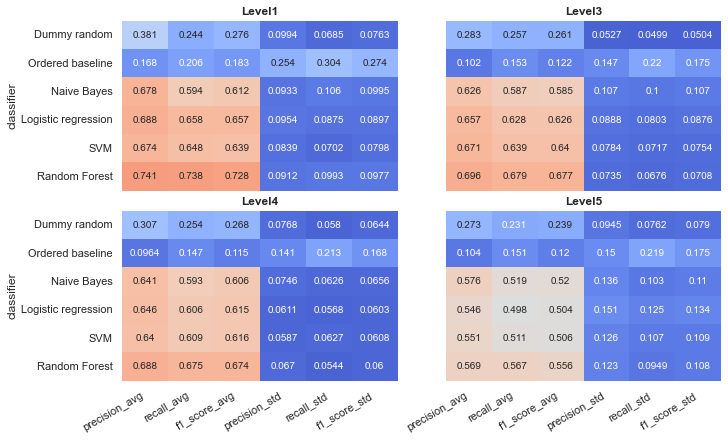

In [29]:
levels_best_classifier_score = {}

fig, axs = plt.subplots(2,2, constrained_layout=True,figsize=[10,6])
index = 0
FSCORE_INDEX = 2
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
      
    col = index % 2
    row = index // 2
    cbar = False
    if col == 2:
        cbar= True
    sns.heatmap(levels_results_grid_stats[level_key], ax = axs[row,col], vmin=0, vmax=1,cmap="coolwarm", annot=True,fmt=".3g", cbar=cbar)
    axs[row,col].set_title(level_key,fontweight='bold')
    if row == 0 :
        axs[row,col].get_xaxis().set_visible(False)
    else :     
        for label in axs[row,col].get_xticklabels():
            label.set_ha("right")
            label.set_rotation(30)
    if col !=0 :
        axs[row,col].get_yaxis().set_visible(False)
    
    best_classifier = levels_results_grid_stats[level_key].sort_values(by=["f1_score_avg"], ascending=False).iloc[0]
    levels_best_classifier_score[level_key] = best_classifier[FSCORE_INDEX]
    print(f"Best classifier : {best_classifier.name}, F1_score : {best_classifier[FSCORE_INDEX]}")
    index += 1
plt.savefig(f"outputdata/Pyrates_performancetable_hypertuning_{EXPORT_SUFFIX}.png")
plt.show()

## 9) Compute confusion matrices

**From this point onward we focus on examining the best classifier only (i.e., the one that yield the best performances).**

In [30]:
#for now we only do it for one model
best_classifier = "Random Forest"

Confusion matrices are generated both in a normalized way (proportion of correct prediction), and in a absolute way (total number of correct predictions).

------------------ Normalized Matrices ------------------
------------------ Level1  ------------------


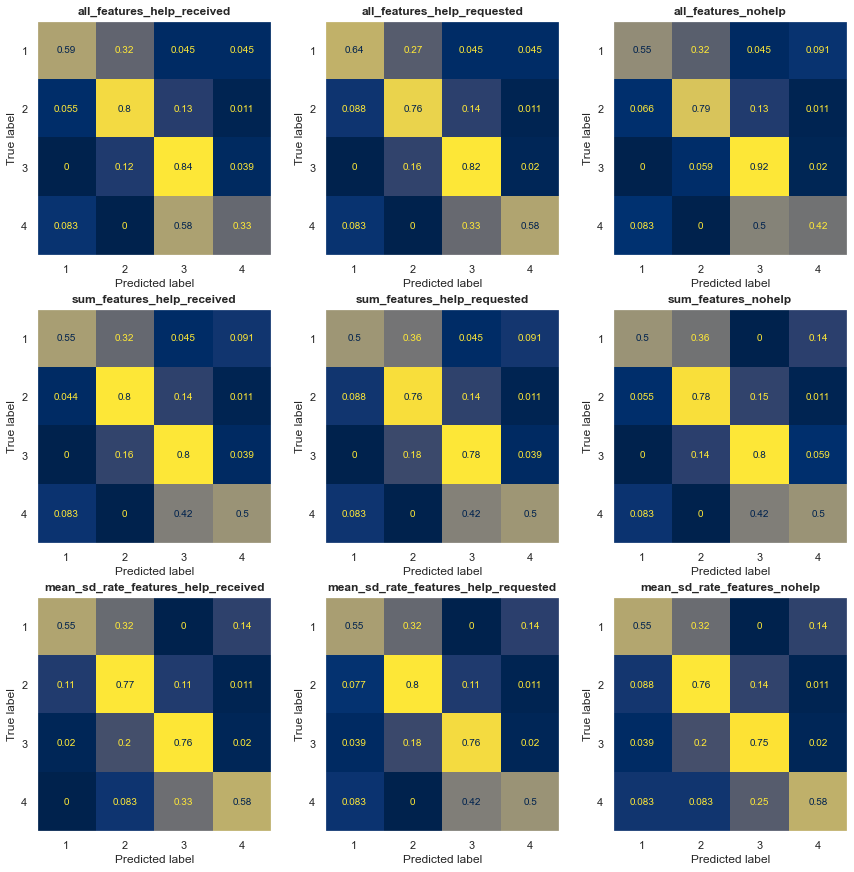

------------------ Level3  ------------------


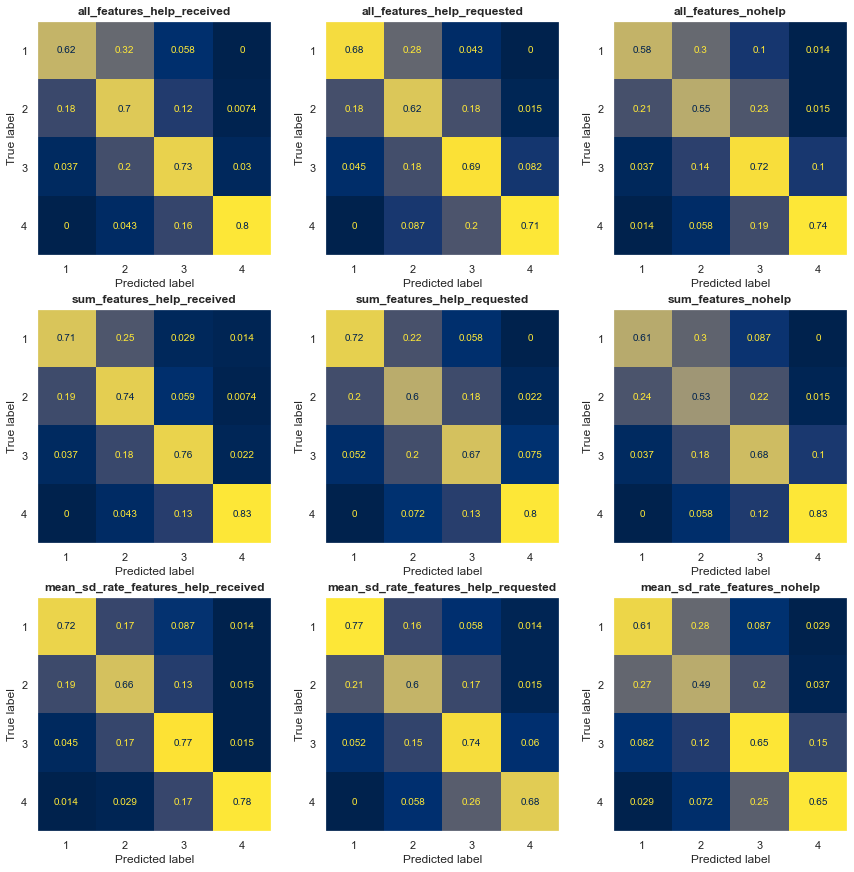

------------------ Level4  ------------------


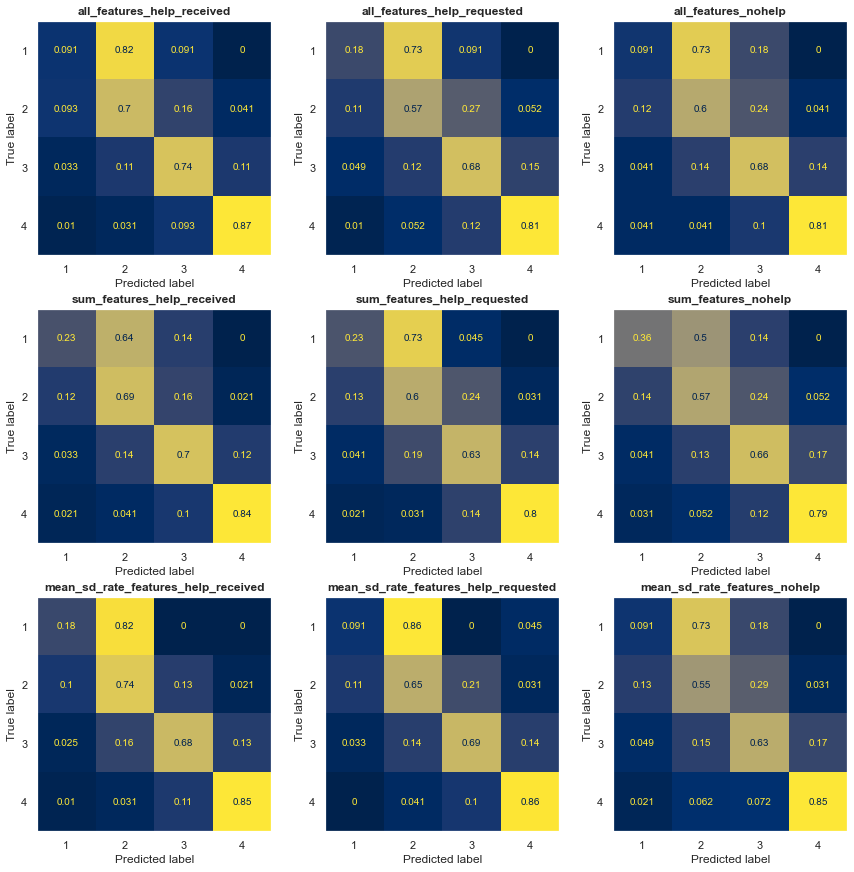

------------------ Level5  ------------------


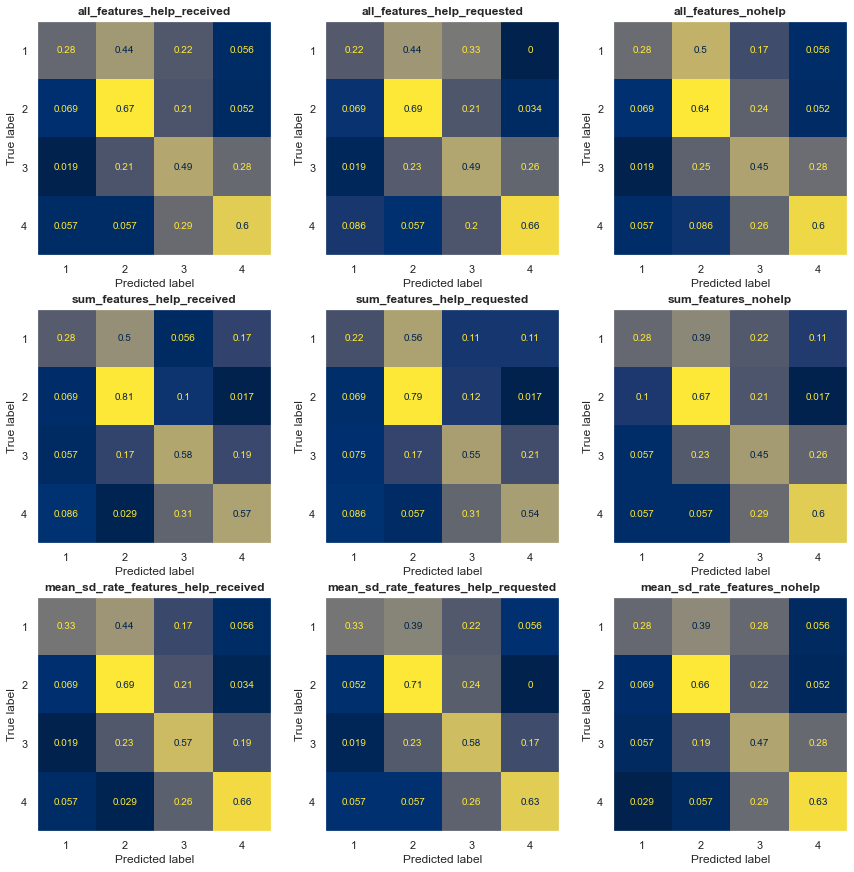

In [31]:
print(f"------------------ Normalized Matrices ------------------")
for level_key in levels_grid_classifier.keys():
    index = 0
    fig, axs = plt.subplots(3,3, constrained_layout=True,figsize=[12,12])
    
    print(f"------------------ {level_key}  ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        col = index % 3
        row = index // 3
        level_test_set_labels = pred_labels[level_key][fset_key][best_classifier]
        level_test_set_predictions = pred_results[level_key][fset_key][best_classifier] 
        ConfusionMatrixDisplay.from_predictions(level_test_set_labels, level_test_set_predictions, ax = axs[row,col], colorbar = False, cmap="cividis", normalize="true")

        axs[row,col].grid(False)
        axs[row,col].set_title(fset_key,fontweight='bold')
        #sns.heatmap(levels_results_grid_stats[level_key][["precision_m","recall_m","f1_score_m"]], yticklabels= [best_classifier], xticklabels= ["Precision","Recall","F1_score"], vmin=0, vmax=1,cmap="coolwarm", annot=True,fmt=".3g", cbar=False, ax=axs[2*row+1,col])
        index +=1
    plt.savefig(f"outputdata/Pyrates_confmatrelative_hypertuning_{best_classifier}_{EXPORT_SUFFIX}.png")
    plt.show()

------------------ Absolute Matrices ------------------
------------------ Level1  ------------------


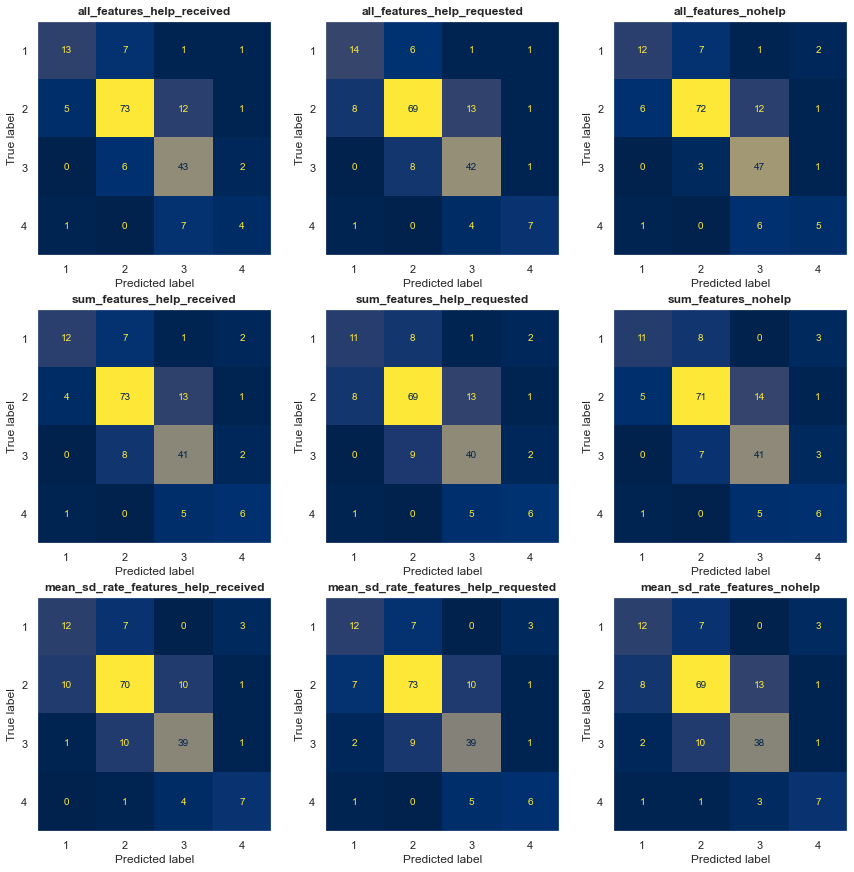

------------------ Level3  ------------------


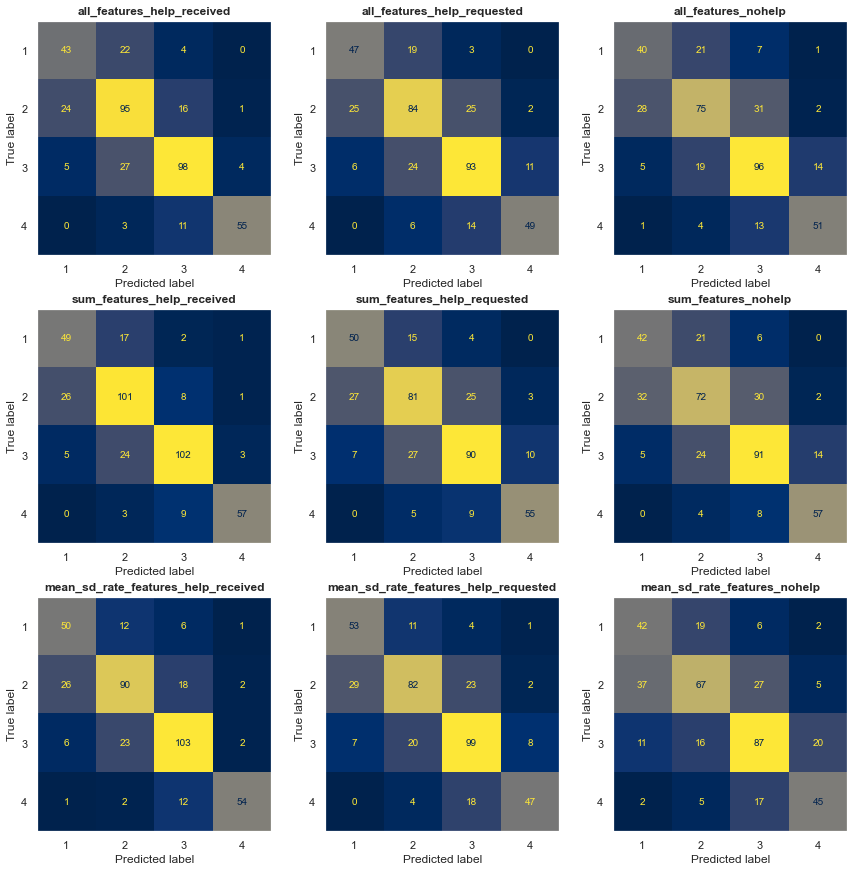

------------------ Level4  ------------------


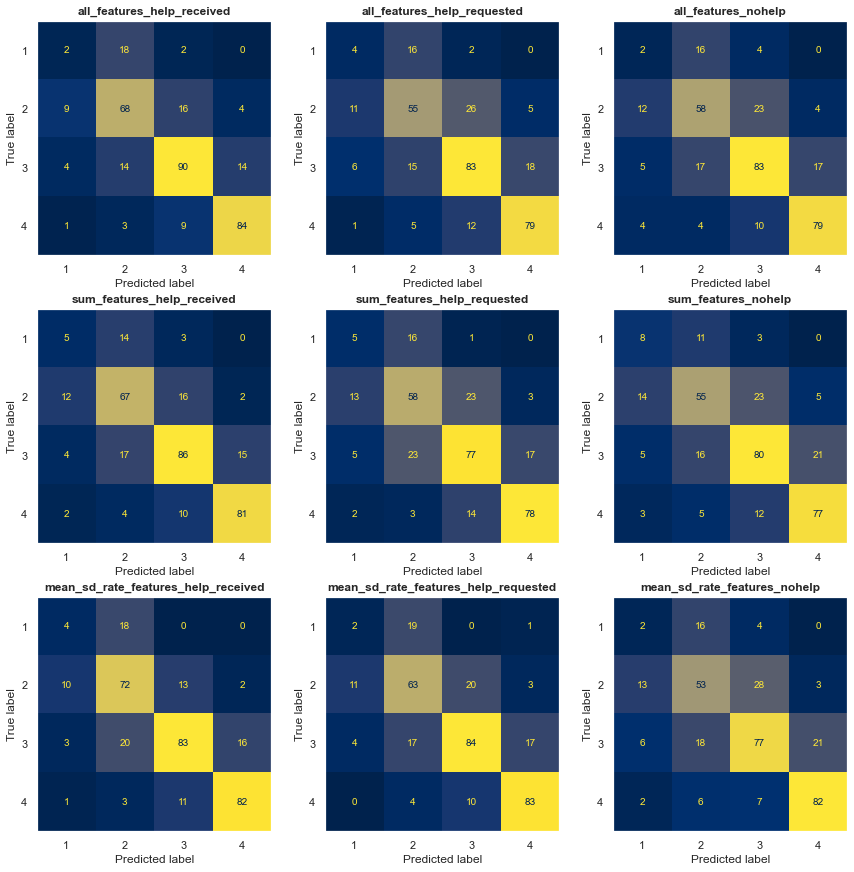

------------------ Level5  ------------------


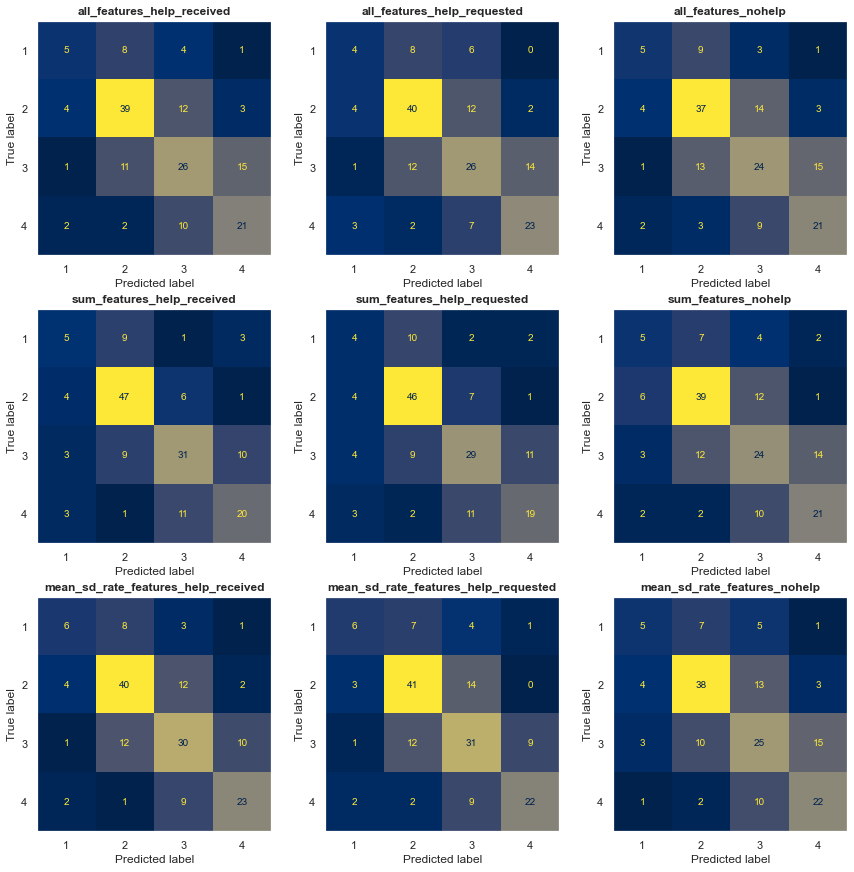

In [32]:
print(f"------------------ Absolute Matrices ------------------")
for level_key in levels_grid_classifier.keys():
    index = 0
    fig, axs = plt.subplots(3,3, constrained_layout=True,figsize=[12,12])
    
    print(f"------------------ {level_key}  ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        col = index % 3
        row = index // 3
        level_test_set_labels = pred_labels[level_key][fset_key][best_classifier]
        level_test_set_predictions = pred_results[level_key][fset_key][best_classifier] 
        ConfusionMatrixDisplay.from_predictions(level_test_set_labels, level_test_set_predictions, ax = axs[row,col], colorbar = False, cmap="cividis", normalize=None)

        axs[row,col].grid(False)
        axs[row,col].set_title(fset_key,fontweight='bold')
        #sns.heatmap(levels_results_grid_stats[level_key][["precision_m","recall_m","f1_score_m"]], yticklabels= [best_classifier], xticklabels= ["Precision","Recall","F1_score"], vmin=0, vmax=1,cmap="coolwarm", annot=True,fmt=".3g", cbar=False, ax=axs[2*row+1,col])
        index +=1
    plt.savefig(f"outputdata/Pyrates_confmatabsolute_hypertuning_{best_classifier}_{EXPORT_SUFFIX}.png")
    plt.show()

## 10) Most important features

We compute and export the most important features selected in the best classifier to further understand what the model actually learned.
In our case the best classifiers was Random Forest and feature important is computed using the permutation feature importance feature of Sklearn.

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled : https://scikit-learn.org/stable/modules/permutation_importance.html

/!\ When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important.

In [33]:
resimportance = []

for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    
    for fset_key, fset_columns in FEATURES_SETS.items():
        print(f"    --------------- {fset_key} ---------------")
        
        fset_dataframe = level_processed_dataframe[fset_columns]
    
        for k in range(NBFOLDS):
            print(f"------------------ {k} ------------------")      
            (level_train_set_index, level_test_set_index) = cv_split_indices[level_key][k]
            level_train_set = fset_dataframe.iloc[level_train_set_index]
            level_test_set = fset_dataframe.iloc[level_test_set_index]

            #level_features, level_labels, level_groups  = feature_label_group_split(fset_dataframe) #for the baselines
            level_train_set_features, level_train_set_labels, level_train_set_groups  = feature_label_group_split(level_train_set)
            level_test_set_features, level_test_set_labels  = feature_label_split(level_test_set)

            level_permutation_importance = permutation_importance(levels_grid_classifier[level_key][fset_key][best_classifier][k], level_train_set_features, level_train_set_labels,scoring="f1_weighted", n_repeats=10,random_state=42, n_jobs=-1)
            resimportance += [{"level_key": level_key, \
                     "features_set": fset_key, \
                     "classifier": best_classifier, \
                     "K": k, \
                     "feature": level_train_set_features.keys()[i],  \
                     "importance": level_permutation_importance.importances_mean[i] } \
                    for i in range(len(level_permutation_importance.importances_mean)) \
                    ]

levels_grid_features_importance = pd.DataFrame.from_records(resimportance) 
print("Done")


------------------ Level1 ------------------
    --------------- all_features_help_received ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- all_features_help_requested ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- all_features_nohelp ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- sum_features_help_received ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 --------

Display the feature importance values in charts

------------------ Feature importance ------------------


------------------ Level1  ------------------
-------------------------- all_features_nohelp  ----------------------------
-------------------------- sum_features_nohelp  ----------------------------
-------------------------- mean_sd_rate_features_nohelp  ----------------------------
------------------ Level3  ------------------
-------------------------- all_features_nohelp  ----------------------------
-------------------------- sum_features_nohelp  ----------------------------
-------------------------- mean_sd_rate_features_nohelp  ----------------------------
------------------ Level4  ------------------
-------------------------- all_features_nohelp  ----------------------------
-------------------------- sum_features_nohelp  ----------------------------
-------------------------- mean_sd_rate_features_nohelp  ----------------------------
------------------ Level5  ------------------
-------------------------- all_features_nohelp  ----------------------------
-------------------

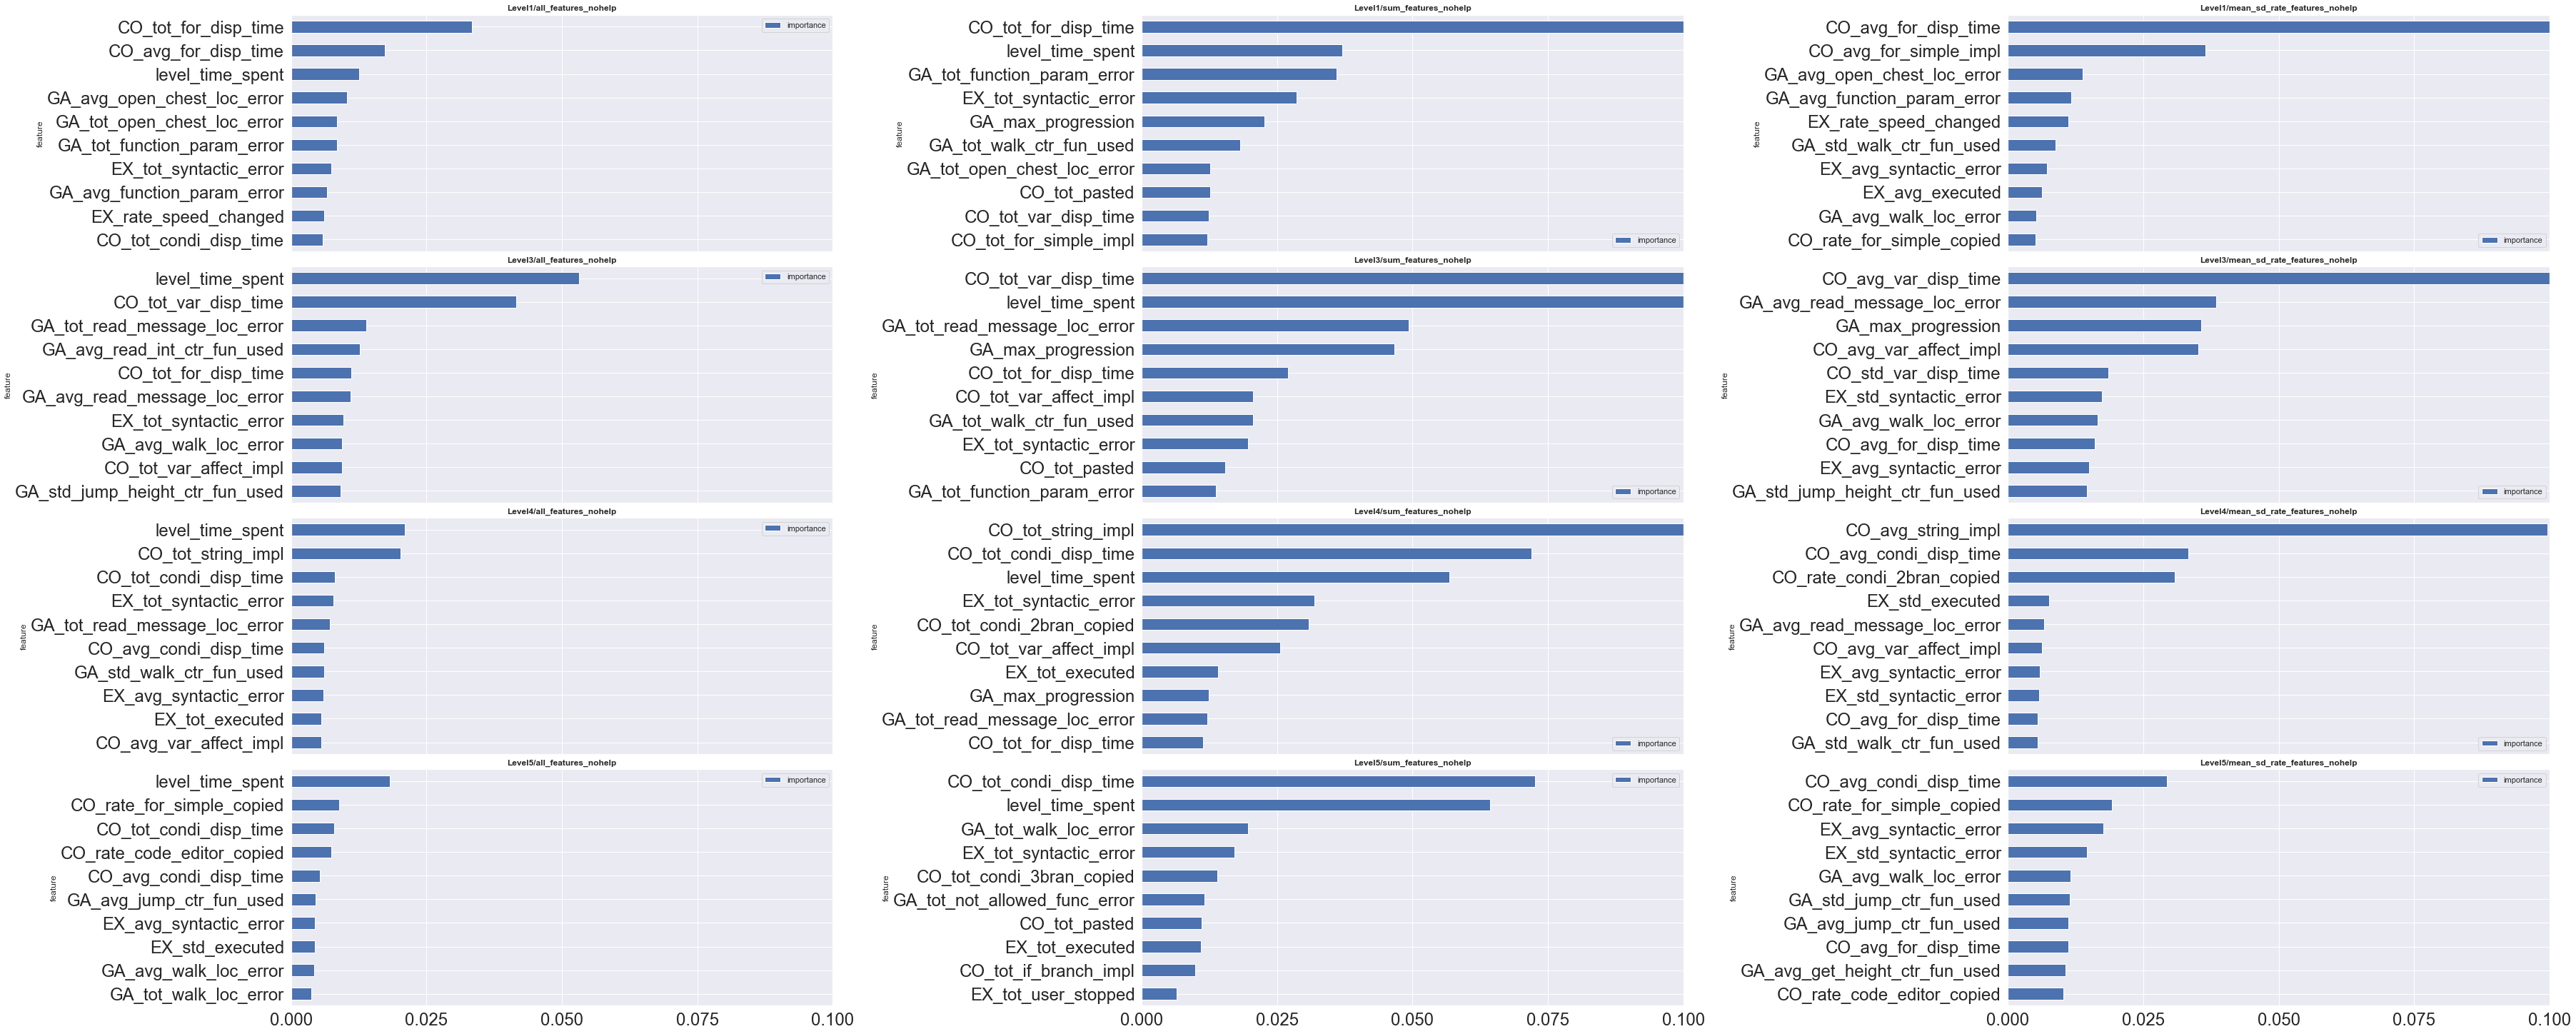

In [34]:
#Feature importance per level and feat set
print(f"------------------ Feature importance ------------------")
fig, axs = plt.subplots(4,3, constrained_layout=True,figsize=[50,20])
index = 0

for level_key in levels_grid_classifier.keys():
    print(f"------------------ {level_key}  ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        if "nohelp" not in fset_key:
            continue
        print(f"-------------------------- {fset_key}  ----------------------------")
        col = index % 3
        row = index // 3
        #level_test_set_labels = pred_labels[level_key][fset_key][best_classifier]
        #level_test_set_predictions = pred_results[level_key][fset_key][best_classifier] 
        #ConfusionMatrixDisplay.from_predictions(level_test_set_labels, level_test_set_predictions, ax = axs[row,col], colorbar = False, cmap="cividis", normalize="true")
        imp = levels_grid_features_importance[(levels_grid_features_importance["level_key"]==level_key) & \
                                      (levels_grid_features_importance["features_set"]==fset_key)]
        imp = imp.groupby(by=["feature"]).mean()
        imp = imp.sort_values(by="importance", ascending=False).head(10).drop("K", axis=1)
        imp.plot.barh(ax = axs[row,col])
        
        #axs[row,col].grid(False)
        axs[row,col].invert_yaxis()
        axs[row,col].set_xlim([0, 0.1])
        axs[row,col].set_xticks([0,0.025,0.05,0.075,0.1])
        for label in (axs[row,col].get_xticklabels() + axs[row,col].get_yticklabels()):
            label.set_fontsize(24)
        if row != 3:
            axs[row,col].set_xticklabels(["","","","",""])
        axs[row,col].set_title(f"{level_key}/{fset_key}",fontweight='bold')
        #sns.heatmap(levels_results_grid_stats[level_key][["precision_m","recall_m","f1_score_m"]], yticklabels= [best_classifier], xticklabels= ["Precision","Recall","F1_score"], vmin=0, vmax=1,cmap="coolwarm", annot=True,fmt=".3g", cbar=False, ax=axs[2*row+1,col])
        index +=1
plt.savefig(f"outputdata/Pyrates_featureimp_hypertuning_{best_classifier}_{EXPORT_SUFFIX}.png")
plt.show()
    
    


# Pickle and CSV dumps

In [35]:
# Models with no hyperparameter tuning
if levels_results is not None:
    levels_results.to_csv(f"outputdata/Pyrates_model_results_notuning_{NBFOLDS}folds{EXPORT_SUFFIX}.csv", index=False)
    with open(f"pickle/levels_results_notuning{EXPORT_SUFFIX}", 'wb') as f:
        pickle.dump(levels_results, f)
        
# Models with hyperparameter tuning    
#save results as a pickle and a CSV
if levels_results_grid is not None:
    levels_results_grid.to_csv(f"outputdata/Pyrates_model_results_hypertuning_{NBFOLDS}folds{EXPORT_SUFFIX}.csv", index=False)
    with open(f"pickle/levels_results_hypertuning{EXPORT_SUFFIX}", 'wb') as f:
        outputall = {
            "grid_results": levels_results_grid,    
            "grid_trained_classifiers": levels_grid_classifier,
            "grid_predictions":pred_results,
            "grid_true_labels": pred_labels
        }
        pickle.dump(outputall, f) 

#feature importance values
if levels_grid_features_importance is not None:
    levels_grid_features_importance.to_csv(f"outputdata/Pyrates_model_featureimp_hypertuning_{best_classifier}_{NBFOLDS}folds_{EXPORT_SUFFIX}.csv", index=False)
    with open(f"pickle/levels_results_featuresimportance{EXPORT_SUFFIX}", 'wb') as f:
        pickle.dump(levels_grid_features_importance, f)
    